# Predicting Breast Cancer Diagnosis Using RandomForest

This dataset is from the UCI Machine Learning Repository, downloaded from Kaggle. Link [here](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Ten real-valued features are computed for each cell nucleus:

a) **radius** (mean of distances from center to points on the perimeter)<br>
b) **texture** (standard deviation of gray-scale values)<br>
c) **perimeter**<br>
d) **area**<br>
e) **smoothness** (local variation in radius lengths)<br>
f) **compactness** (perimeter^2 / area - 1.0)<br>
g) **concavity** (severity of concave portions of the contour)<br>
h) **concave points** (number of concave portions of the contour)<br>
i) **symmetry**<br>
j) **fractal dimension** ("coastline approximation" - 1)<br>

The columns names ending with "se" or "worst" refer to the standard error or the maximum of that feature observed, respectively.

The target column is the binary "diagnosis" column.

# Summary

#### RandomForest after 5-fold cross-validation
    * Unscaled
        Test accuracy:  0.9031
        Recall: 0.8361
    * Scaled
        Test accuracy: 0.9031
        Recall: 0.8361
    * Unscaled after dropping low-importance columns:
        Test accuracy: 0.9118
        Recall: 0.8583
    * Scaled after dropping low_importance columns:
        Test accuracy: 0.9118
        Recall: 0.8583


In [82]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer

In [57]:
cancer = pd.read_csv('breast_cancer.csv')

cancer = cancer.drop(['Unnamed: 32', 'id'], axis = 1)

In [58]:
diag_map = {'B':0, 'M': 1}

cancer['diagnosis'] = cancer['diagnosis'].map(diag_map)

In [59]:
X = cancer.drop('diagnosis', 1)
y = cancer['diagnosis']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [61]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Unscaled

In [62]:
rfc_grid = {
    'n_estimators': [5, 10, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [5, 20, 30]
}

model_rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid = rfc_grid, verbose = 1, n_jobs = -1)
model_rfc_grid.fit(X_train, y_train)

print(model_rfc_grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.9s


{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    8.8s finished


In [63]:
#The best_params_ from the gridsearch lead to overfitting, so I used different hyperparams
# I specify a random state to keep the numbers consistent.

%time
model_rfc = RandomForestClassifier(criterion = 'entropy', 
                                   max_depth = 20, 
                                   n_estimators = 50, 
                                   min_samples_leaf = 5, 
                                   random_state = 20)
model_rfc.fit(X_train, y_train)

y_pred_rfc = model_rfc.predict(X_test)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rfc),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_rfc.score(X_train, y_train)))
print('Test Score: {}'.format(model_rfc.score(X_test, y_test)))
print(classification_report(y_test, y_pred_rfc))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.9868131868131869
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41


In [83]:
cv_scores = cross_val_score(model_rfc, X_test, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_rfc, X_test, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

Mean cross val accuracy: 0.9031620553359684
Mean cross val recall: 0.836111111111111


In [65]:
importances = model_rfc_grid.best_estimator_.feature_importances_
im_df = pd.DataFrame({"feat": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,feat,importance
23,area_worst,0.171404
27,concave points_worst,0.162212
22,perimeter_worst,0.133412
7,concave points_mean,0.076942
20,radius_worst,0.071846
2,perimeter_mean,0.066865
26,concavity_worst,0.055139
13,area_se,0.046682
6,concavity_mean,0.034763
3,area_mean,0.024147


# Scaled

In [66]:
model_rfc_grid_s = GridSearchCV(RandomForestClassifier(), param_grid = rfc_grid, verbose = 1, n_jobs = -1)
model_rfc_grid_s.fit(X_train_scaled, y_train)

print(model_rfc_grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s


{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.4s finished


In [67]:
%time
model_rfc_scale = RandomForestClassifier(criterion = 'entropy',
                                         max_depth = 20, 
                                         n_estimators = 50, 
                                         min_samples_leaf = 5,
                                        random_state = 20)
model_rfc_scale.fit(X_train_scaled, y_train)

y_pred_rfc_s = model_rfc_scale.predict(X_test_scaled)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rfc_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_rfc_scale.score(X_train_scaled, y_train)))
print('Test Score: {}'.format(model_rfc_scale.score(X_test_scaled, y_test)))
print(classification_report(y_test, y_pred_rfc_s))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.9868131868131869
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41


In [84]:
cv_scores = cross_val_score(model_rfc_scale, X_test_scaled, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_rfc_scale, X_test_scaled, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

Mean cross val accuracy: 0.9031620553359684
Mean cross val recall: 0.836111111111111


In [69]:
importances = model_rfc_grid_s.best_estimator_.feature_importances_
im_df = pd.DataFrame({"feat": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,feat,importance
20,radius_worst,0.170273
22,perimeter_worst,0.153941
7,concave points_mean,0.101023
27,concave points_worst,0.095107
23,area_worst,0.077236
26,concavity_worst,0.074388
2,perimeter_mean,0.061490
3,area_mean,0.047408
6,concavity_mean,0.031742
21,texture_worst,0.028690


# Dropping low-importance columns

Using a threshold of 0.1, I drop columns with low importance and test the accuracy of the new model.

## Unscaled

In [70]:
cancer_dropped_u = cancer.drop(columns=['concave points_se'
               ,'symmetry_se'
               ,'compactness_se'
               ,'smoothness_se'
               ,'fractal_dimension_mean'
               ,'concavity_se'
               ,'texture_se'
               ,'fractal_dimension_se'
               ,'fractal_dimension_worst'
               ,'symmetry_mean', 
                'smoothness_worst',
                'compactness_mean', 
                'radius_se', 
                'smoothness_mean',
                'perimeter_se'
                ])

X = cancer_dropped_u.drop(columns = 'diagnosis')

y = cancer_dropped_u['diagnosis']

X_train_op, X_test_op, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [71]:
rfc_grid = {
    'n_estimators': [5, 10, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [5, 20, 30]
}

model_rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid = rfc_grid, verbose = 1, n_jobs = -1)
model_rfc_grid.fit(X_train_op, y_train)

print(model_rfc_grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.6s


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.2s finished


In [72]:
%time
model_rfc_op = RandomForestClassifier(criterion = 'entropy',
                                      max_depth = 10, 
                                      n_estimators = 50, 
                                      min_samples_leaf = 5,
                                     random_state = 20)
model_rfc_op.fit(X_train_op, y_train)

y_pred_rfc_op = model_rfc_op.predict(X_test_op)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rfc_op),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_rfc_op.score(X_train_op, y_train)))
print('Test Score: {}'.format(model_rfc_op.score(X_test_op, y_test)))
print(classification_report(y_test, y_pred_rfc))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.9846153846153847
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41


In [85]:
cv_scores = cross_val_score(model_rfc_op, X_test_op, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_rfc_op, X_test_op, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

Mean cross val accuracy: 0.9118577075098815
Mean cross val recall: 0.8583333333333332


## Scaled

In [74]:
cancer_dropped_s = cancer.drop(columns=['concave points_se'
                                        ,'fractal_dimension_worst'
                                        ,'smoothness_mean'
                                        ,'texture_se'
                                        ,'fractal_dimension_se'
                                        ,'symmetry_se'
                                        ,'compactness_se'
                                        ,'symmetry_mean'
                                        ,'fractal_dimension_mean'
                                        ,'smoothness_se'
                                        ,'concavity_se'
                                        ,'symmetry_worst'])

X = cancer_dropped_s.drop(columns = 'diagnosis')

y = cancer_dropped_s['diagnosis']

X_train_op, X_test_op, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [75]:
scaler = StandardScaler()
scaler.fit(X_train_op)

X_train_scaled_op = scaler.transform(X_train_op)
X_test_scaled_op = scaler.transform(X_test_op)

In [76]:
model_rfc_grid_s = GridSearchCV(RandomForestClassifier(), param_grid = rfc_grid, verbose = 1, n_jobs = -1)
model_rfc_grid_s.fit(X_train_scaled_op, y_train)

print(model_rfc_grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.5s


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    5.6s finished


In [77]:
%time
model_rfc_scale_op = RandomForestClassifier(criterion = 'entropy', 
                                            max_depth = 20, 
                                            n_estimators = 50,
                                            min_samples_leaf = 5,
                                           random_state = 20)
model_rfc_scale_op.fit(X_train_scaled_op, y_train)

y_pred_rfc_s = model_rfc_scale_op.predict(X_test_scaled_op)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rfc_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_rfc_scale_op.score(X_train_scaled_op, y_train)))
print('Test Score: {}'.format(model_rfc_scale_op.score(X_test_scaled_op, y_test)))
print(classification_report(y_test, y_pred_rfc_s))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.9868131868131869
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41


In [86]:
cv_scores = cross_val_score(model_rfc_scale_op, X_test_scaled_op, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_rfc_scale_op, X_test_scaled_op, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

Mean cross val accuracy: 0.9118577075098815
Mean cross val recall: 0.8583333333333332


# ROC curve unscaled

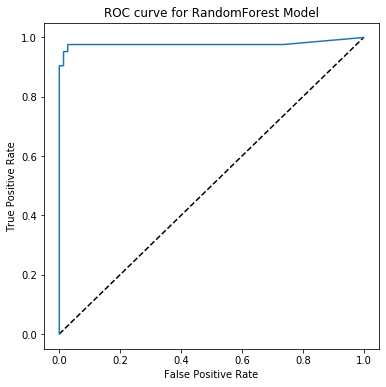

In [79]:
probs = model_rfc.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RandomForest Model')
plt.show()

# ROC curve  scaled

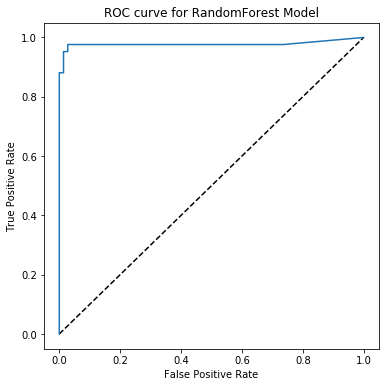

In [80]:
probs = model_rfc_scale.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RandomForest Model')
plt.show()

# ROC curve unscaled optimized

In [81]:
probs = model_rfc_op.predict_proba(X_test_op)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RandomForest Model')
plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 15 and input n_features is 18 

# ROC curve scaled optimized

In [ ]:
probs = model_rfc_scale_op.predict_proba(X_test_scaled_op)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RandomForest Model')
plt.show()

# Model Confidence

## Unscaled

In [ ]:
confidence = model_rfc.predict_proba(X_test)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('RandomForest')
plt.show()

## Scaled

In [ ]:
confidence = model_rfc_scale.predict_proba(X_test_scaled)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('RandomForest')
plt.show()

## Unscaled optimized

In [ ]:
confidence = model_rfc_op.predict_proba(X_test_op)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('RandomForest')
plt.show()

## Scaled Optimized

In [ ]:
confidence = model_rfc_scale_op.predict_proba(X_test_scaled_op)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('RandomForest')
plt.show()